# K-평균 군집화 및 가우시안 혼합 모델

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Kim Hye-mi(khm0308@kaist.ac.kr) </div>

본 코드는 K-평균 군집화 및 가우시안 혼합 모델을 실행하는 코드입니다. 본 코드는 크게 3가지 과정(Cluster Synthesis, K-평균 군집화, 가우시안 혼합모델)으로 이루어져 있으며, 이를 통해 비지도 학습의 한 방법인 군집화 방법을 익힐 수 있습니다.

In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul; icmoon@kaist.ac.kr
@ annotated by Kim Hye-mi; khm0308@kaist.ac.kr
'''

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Cluster Synthesis
아래와 같이 가우시안 혼합 분포를 따르는 확률변수를 생성합니다.
$$ P_X(x) =\sum_{k=1}^{K}\pi_k N(x\space|\space\mu_i, \Sigma_i)$$

* $\pi$는 혼합계수(mixing coeffcient)

In [3]:
# pi_true: pi_true의 instance는 각 random variable의 혼합계수
# mu_true, sigma_true: Multivariate normal distribution의 mean matrix, covariance matrix

pi_true = np.array([0.35, 0.45, 0.2])
mu_true = np.array([[-1, 3], [1, 5], [3,7]])
sigma_true = np.zeros((3, 2, 2))
sigma_true[0] = np.array([[0.9, 0.1], [0.1, 0.9]])/3
sigma_true[1] = np.array([[0.6, 0.4], [0.4, 0.6]])/3
sigma_true[2] = np.array([[0.7, 0.3], [0.3, 0.7]])/3
col = ['red', 'green', 'blue', 'black', 'cyan']

In [4]:
# N: 생성할 random variable의 총 개수
# v[i, j, k]: j번째로 생성된 i번째 random variable(R_i)의 X(k=0) 및 Y(k=1)값
# C[i]: 생성된 i번째 random variable(R_i)의 개수

N = 100
v = np.zeros((len(pi_true), N, 2))
C = np.zeros(len(pi_true), dtype = 'int64')
obs = np.zeros((N, 2))

In [5]:
for i in range(N):
    z = np.random.random()
    idx = 0
    needle = 0
    
    for j in range(len(pi_true)): # 생성할 random variable의 혼합계수에 비례하게 변수를 생성
        if z >= needle and z <= needle + pi_true[j]:
            idx = j
            break
        else:
            needle += pi_true[j]
            
    obs[i] = np.random.multivariate_normal(mu_true[idx], sigma_true[idx]) # 위의 for-statement에서 결정된 idx 값에 따라(혼합계수에 따라) random variable을 생성함
    C[idx] += 1 # R_i가 몇개 생성되었는지 기록
    v[idx, C[idx]] = obs[i] # multivariate normal distribution을 따르는 값을 random variable의 i값 및 빈도별로 저장함

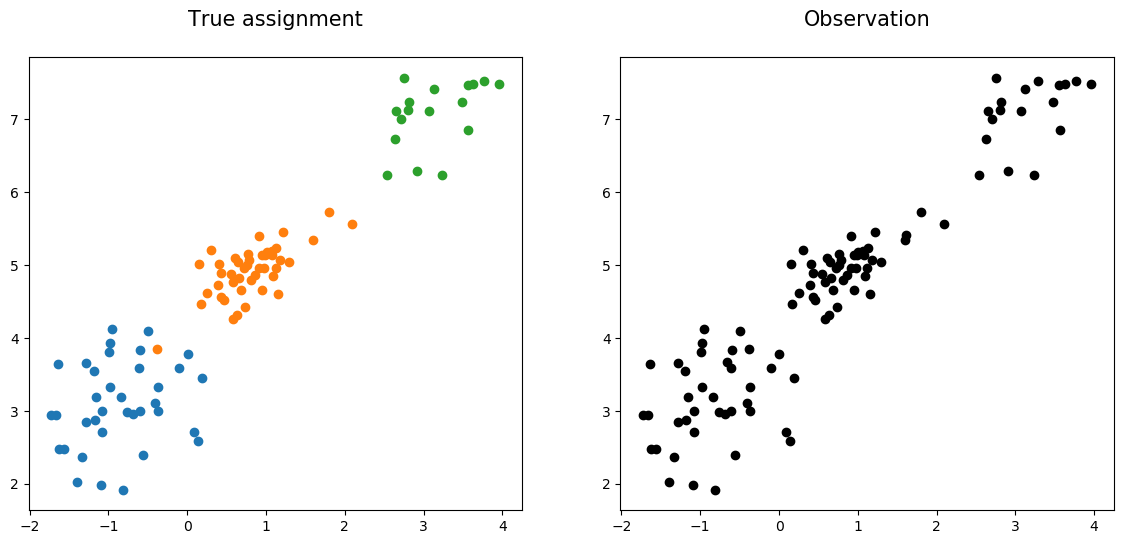

In [6]:
plt.figure(1, figsize=(14, 6), dpi=100)
plt.subplot(121)
plt.title('True assignment\n', fontsize=15)
for i in range(len(pi_true)):
    plt.plot(v[i, 1:C[i], 0], v[i, 1:C[i], 1], 'o')
    
plt.subplot(122)
plt.title('Observation\n', fontsize=15)
plt.plot(obs[:, 0], obs[:, 1], 'ko')

plt.show()

## K-평균 군집화 (K-means Clustering)
$K$-평균 군집화는 집단 내부의 특성을 $K$개로 분류할 수 있다 가정하고 데이터를 가장 가까운 특성에 할당하는 비지도 학습에 속하는 알고리즘 입니다.

목표함수 $J$는 개별 군집에 속한 데이터 포인트와 군집의 무게 중심의 거리를 모두 더한 값으로, 이를 최소화 하는 것이 목표입니다. 목표함수는 다음과 같은 수식으로 나타낼 수 있습니다.

$$J=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk}||x_n-\mu_k||^2$$  
$x_n$: n번째 데이터 포인트 위치  
$\mu_k$: k번째 중심의 위치를 나타내는 결정 변수  
$r_{nk}$: n번째 데이터 포인트가 k번째 군집에 속하면 1, 그렇지 않으면 0인 이진 결정 변수  

$J$의 최적 값을 구하는 과정에서 $r_{nk}$가 이진 결정 변수이므로 J를 $r_{nk}$에 대해 미분하는 것은 불가능합니다. 따라서 중심의 위치 $\mu_k$와 데이터의 할당 정보 $r_{nk}$를 상호적으로(Interacting) 변화시키면서 $J$의 값을 반복적으로 줄여나가는 반복 최적화(Iterative Optimization) 알고리즘으로 $\mu_k$값을 구할 수 있습니다.이렇게 구한 $\mu_k$는 다음과 같이 나타납니다.


$$\mu_k=\frac{\sum_{n=1}^{N} x_n r_{nk}}{\sum_{n=1}^{N} r_{nk}}$$

In [7]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [8]:
k = 5 # 군집의 개수
itrEM = 100 # iteration 횟수
showVisualization = [2, 3, 4, 5, 6, 10, 20] # 군집화된 결과를 가시화 할 iteration 횟수

In [9]:
centroid = np.zeros((itrEM, k, 2)) # iterEM(iteration)에 따른 k-th cluster의 무게중심 (X, Y)
sumDistance = np.zeros(itrEM-1) # 목표함수: 데이터 포인트와 군집의 무게 중심의 거리를 모두 더한 값
assignment = np.zeros(N, dtype = 'int64') # N번째 데이터 포인트가 속하는 군집 값

In [10]:
for i in range(k):
    centroid[0, i, :] = obs[i, :] # K개의 데이터 포인트를 무게중심 초기값으로 설정

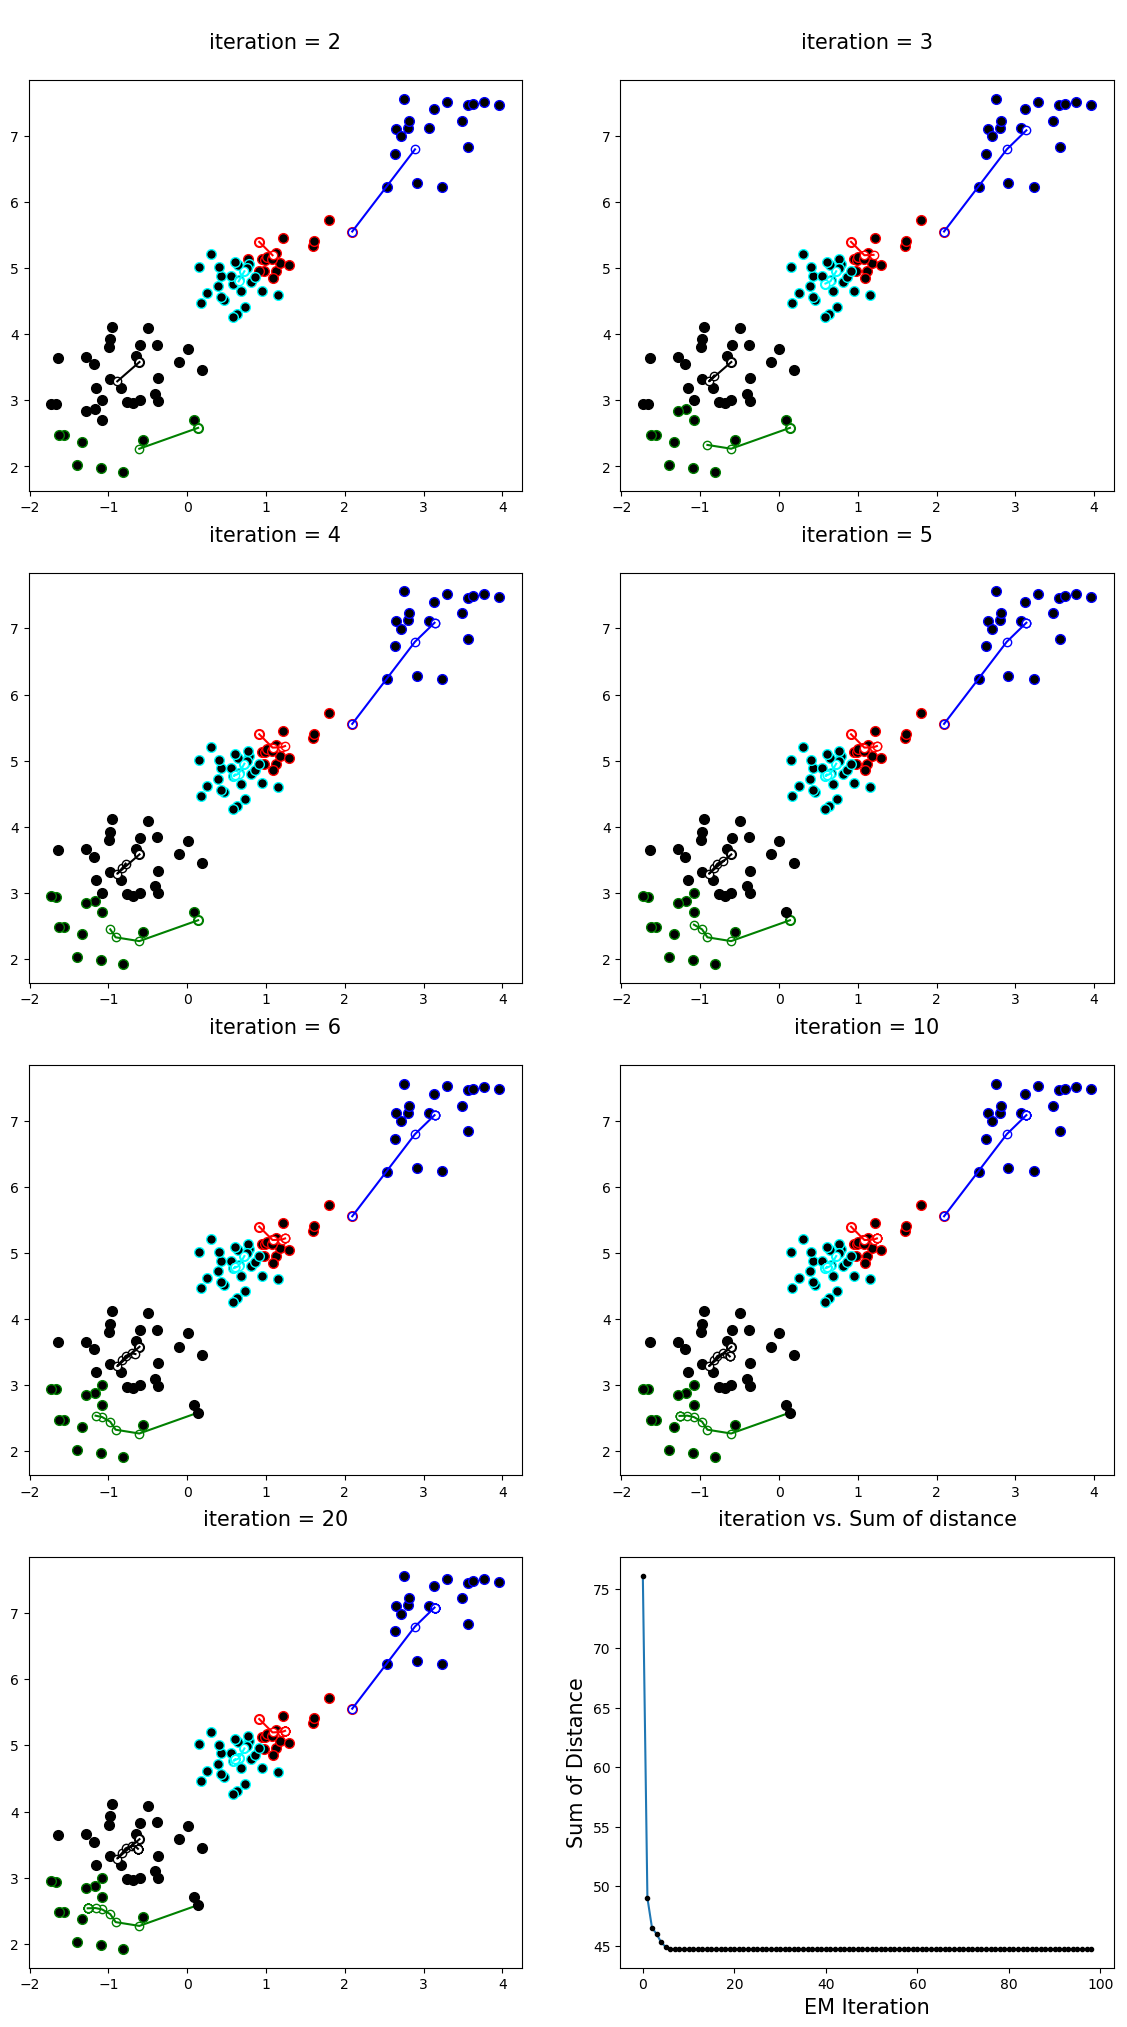

In [11]:
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):       
    for j in range(N): # 생성한 모든 random variable에 대하여 군집화를 실시
        idxK = 0
        minDist = distance(centroid[i-1, 0, :], obs[j, :]) # 첫번째 군집의 무게중심에 대한 데이터 포인트의 거리를 minDist의 초기값으로 설정
        
        #각 데이터 포인트를 가장 가까운 군집에 할당하는 과정 - EM알고리즘에서 E과정
        for l in range(1, k):
            dist = distance(centroid[i-1, l, :], obs[j, :]) # 각각의 무게중심에 대한 데이터 포인트의 거리 계산
            
            if minDist > dist: # 첫번째 군집보다 가까운 군집이 존재할 때, 데이터 포인트가 속하는 군집을 변경해 줌
                minDist = dist
                idxK = l
        assignment[j] = idxK
        sumDistance[i-1] += distance(centroid[i-1, idxK, :], obs[j, :]) # 목표함수 계산
    
    cntGroups = np.zeros(k) + 1e-5 # 해당 군집에 속하는 데이터 포인트가 0인 경우를 대비하여 1e-5를 더해줌
    
    for j in range(N):        
        cntGroups[assignment[j]] += 1 # 각 군집에 속하는 데이터 포인트 계산
        centroid[i, assignment[j]] += obs[j] # 각 군집에 속하는 데이터 포인트의 좌표값을 더해줌
    
    for j in range(k):
        centroid[i, j] /= cntGroups[j] # 각 군집의 무게중심 값 계산 - EM알고리즘에서 M과정
    
    if i in showVisualization: # 가시화 할 iterEM일 경우 아래의 과정을 수행함
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize = 15)
        plotN += 1
        
        for j in range(k):
                  
            points = np.zeros((int(cntGroups[j]), 2))
            cntTemp = 0
            
            # 해당 데이터포인트가 j 군집에 속할 경우 points에 좌표를 저장함
            for l in range(N):
                if assignment[l] == j: 
                    points[cntTemp] = obs[l]
                    cntTemp += 1
            
            # j 군집에 속하는 point를 검정색 점으로 나타내고, 테두리는 col[j]로 나타냄
            plt.plot(points[:, 0], points[:, 1], 'ko', markeredgecolor = col[j], markersize = 7, markeredgewidth = 1) #검정
            # 초기 군집의 무게중심과 itrEM 후의 무게중심을 흰 점으로 나타내고 테두리는 col[j]로 나타냄
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], 'wo', markeredgecolor = col[j])
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], color = col[j])

# iteration에 따른 목표함수 값의 변화를 나타냄
plt.subplot(4, 2, 8)
plt.title('iteration vs. Sum of distance\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Sum of Distance', fontsize = 15)
plt.plot(sumDistance[:])
plt.plot(sumDistance[:], 'ko', markersize = 3)

plt.show()

### 결과해석부
각 군집은 테두리 색으로 구분되며 검은색 점은 개별 데이터 포인트를, 흰색 점은 군집의 중심을 나타냅니다. 그래프 iteration = 2, 3, 4, 5, 6, 10, 20을 통해 반복적인 군집화 과정에서 군집의 중심과 형태가 함께 변하는 것을 확인할 수 있습니다.

마지막 그래프는 K-평균 군집화의 반복 횟수에 따른 목표함수의 값 변화를 나타냅니다. 이 그래프는 처음 몇 번의 반복은 목표함수의 값을 개선시키지만, 특정 반복 횟수를 넘어가면 목표 함수의 개선이 없어 더 이상의 반복은 무의미하함을 확인할 수 있습니다. 이렇게 반복 최적화 과정에서 특정 값으로 수렴한 해를 지역 최적해(Local Optimum)라고 합니다.

## 가우시안 혼합 모델 (Gaussian Mixture Model)
위의 K-평균 군집화 알고리즘이 가지는 문제점은 유클리드 거리가 적절하지 않은 경우도 있다는 점, 그리고 하나의 데이터 포인트를 반드시 하나의 군집에 할당해야 한다는 점입니다.(데이터를 특정 군집에만 배치시키기 어려운 경우도 존재할 수 있습니다.) 가우시안 혼합모델은 이 문제점을 해결할 수 있는 자율학습 알고리즘 입니다.

### 약한 군집화
데이터의 보다 유연한 할당을 위해 n번째 데이터가 k번째 군집에 속해 있을 값을 확률 $\space\gamma(z_{nk})$로 설정합니다. 베이즈 정리를 활용하면 다음과 같은 값을 구할 수 있습니다.
$$\gamma(z_{nk}) = \frac{\pi_k N(x_n\space|\space\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j N(x_n\space|\space\mu_j, \Sigma_j)}\color{red}{\space...\space eq\space(1)}$$

### 매개변수 $\mu_k$, $\Sigma_k$, $\pi_k$의 최우추정값
$\mu_k$, $\Sigma_k$는 $L(\pi, \mu, \Sigma)$을 편미분하여 최우추정값을 구할 수 있습니다.  
$$\hat{\mu_k} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})x_n}{\sum_{n=1}^{N} \gamma(z_{nk})}\color{red}{\space...\space eq\space(2)}$$
$$\hat{\Sigma_k} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})(x_n-\hat{\mu_k})(x_n-\hat{\mu_k})^T}{\sum_{n=1}^{N} \gamma(z_{nk})}\color{red}{\space...\space eq\space(3)}$$

$\pi_k$는 음수가 아니며, 합이 1이라는 제약 조건이 있으므로 편미분을 할 때에 라그랑지 방법으로 최우추정값을 구할 수 있습니다.

$$\hat{\pi_k} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})}{N}\color{red}{\space...\space eq\space(4)}$$

### 로그우도값 (Log-Likelihood)
EM알고리즘의 성능은 반복횟수에 따른 로그우도값을 통해 확인할 수 있습니다. 로그우도값의 식은 아래와 같습니다.
$$L(\pi, \mu, \Sigma) = lnP(X=x\space|\space\pi, \mu, \Sigma) = \sum_{n=1}^{N}ln\space(\sum_{k=1}^{K}\pi_k N(x_n\space|\space\mu_k,\Sigma_k))\color{red}{\space...\space eq\space(5)}$$

* $\mu_k, \sigma_k^2$: 혼합모델을 구성하는 확률변수 각각의 평균과 분산   
* $\pi_k$: 개별 확률 변수에 대한 혼합계수

In [12]:
k = 3
itrEM = 100
showVisualization = [1, 2, 4, 8, 16, 32, 99]

In [13]:
mu = np.zeros((itrEM, k, 2))
sigma = np.zeros((itrEM, k, 2, 2))
pi = np.zeros((itrEM, k))
likelihood = np.zeros(itrEM-1) # 로그우도값
assignment = np.zeros((N, k)) # n번째 데이터가 k번째 군집에 속해 있을 확률값

In [14]:
for i in range(k):
    mu[0, i] = obs[i]
    sigma[0, i] = np.eye(2)
    pi[0, i] = 1.0 / k

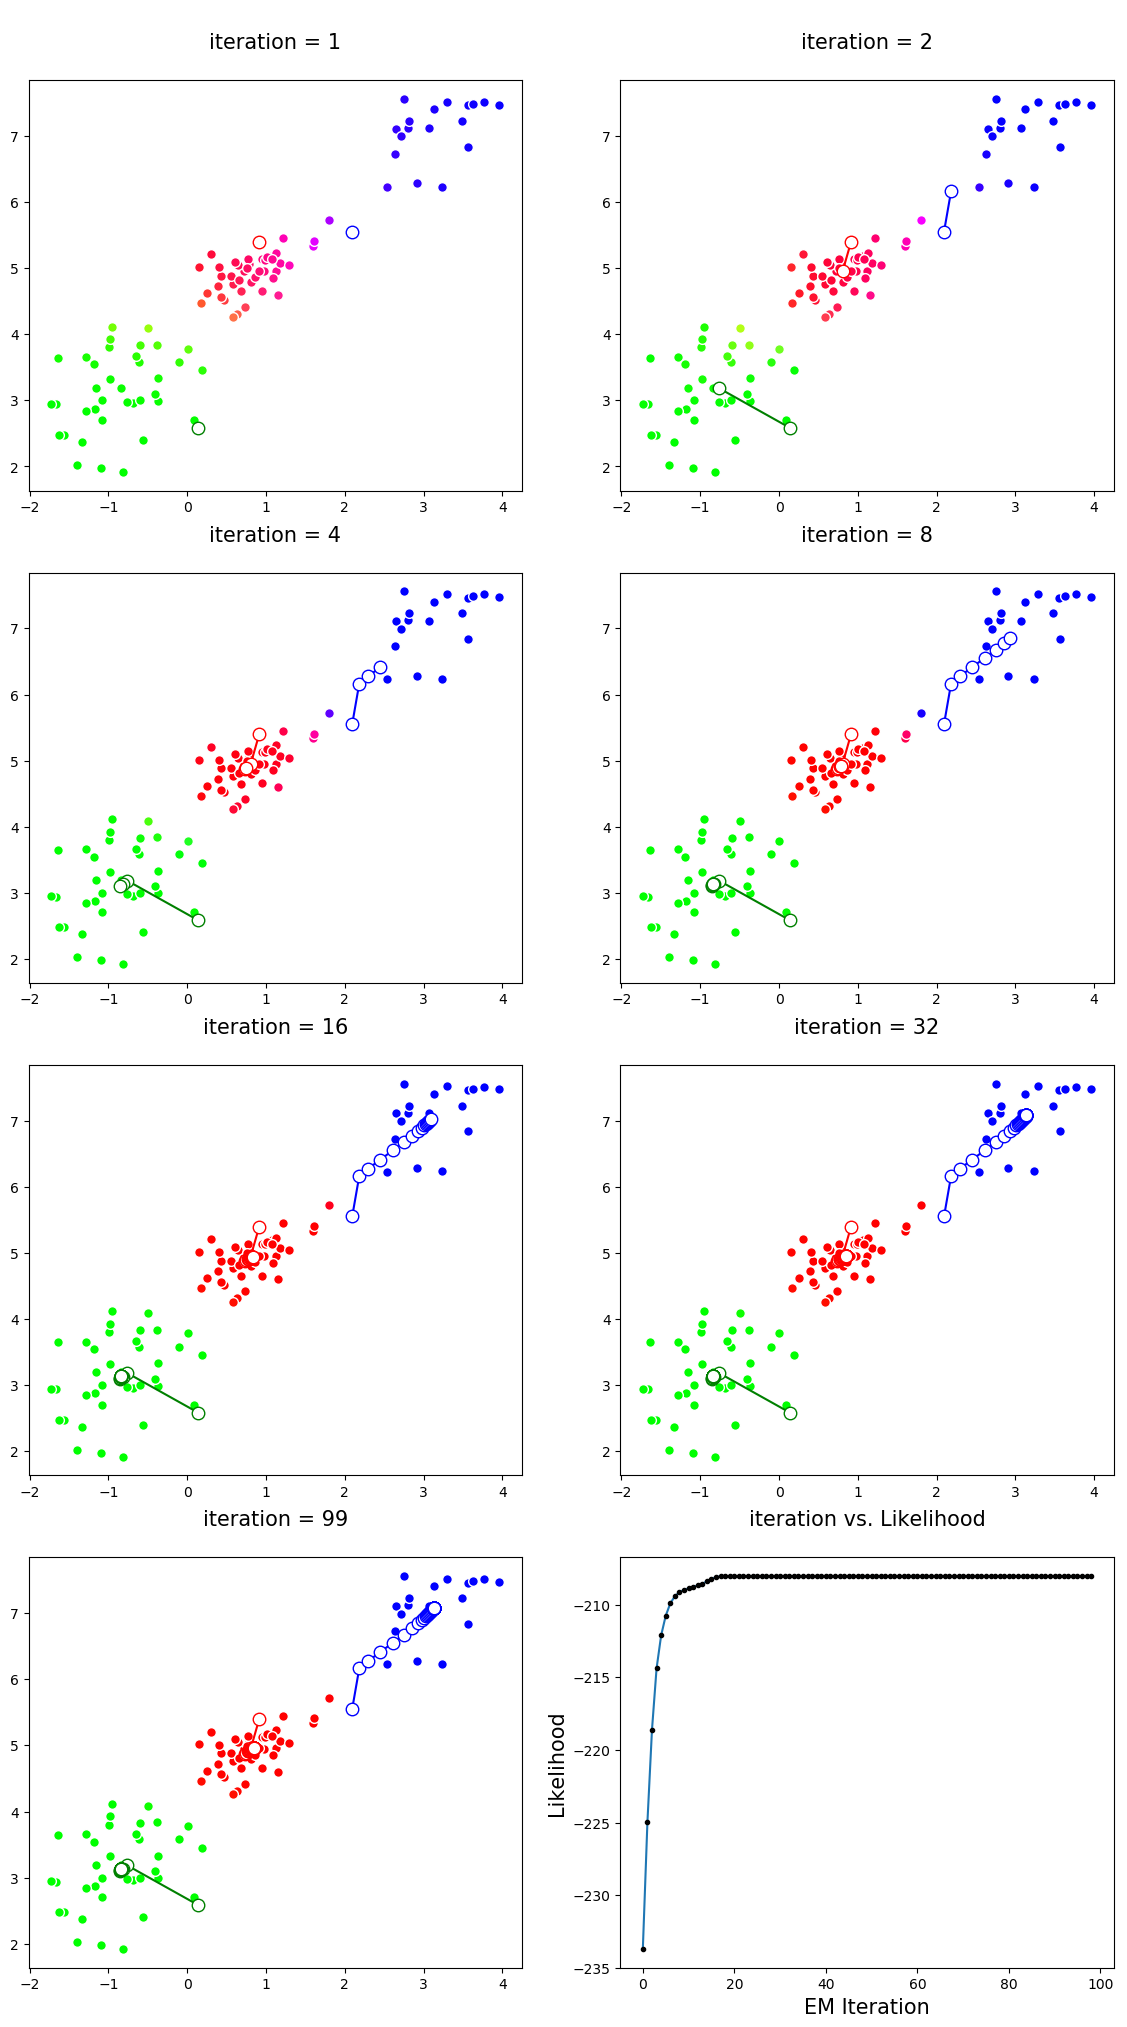

In [15]:
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):
    
    # EM알고리즘 기댓값(E) 과정...eq(1)
    for j in range(N):
        for l in range(k):
            assignment[j, l] = pi[i-1, l] * multivariate_normal.pdf(obs[j, :], mu[i-1, l], sigma[i-1, l])
            
        assignment[j] /= np.sum(assignment[j])
    
    # EM알고리즘의 최대화(M) 과정
    ## mu의 최우추정값을 구하는 과정...eq(2)
    for j in range(k):
        normalize = 0
        mu[i, j] = np.zeros((1,2))
        
        for l in range(N):
            mu[i,j] += assignment[l, j] * obs[l]
            normalize +=  assignment[l, j]
        
        mu[i, j] /= normalize
    
    ## Sigma의 최우추정값을 구하는 과정...eq(3)
    for j in range(k):
        normalize = 0
        sigma[i, j] = np.zeros((2,2))
        
        for l in range(N):
            sigma[i, j] += assignment[l, j] * np.multiply(np.transpose([obs[l] - mu[i, j]]), obs[l] - mu[i, j])
            normalize += assignment[l, j]
            
        sigma[i, j] /= normalize
    
    ## pi의 최우추정값을 구하는 과정...eq(4)
    for j in range(k):
        for l in range(N):
            pi[i, j] += assignment[l, j]
            
        pi[i, j] /= N
        
    ## 로그 우도값(log liklihood)의 계산...eq(5)
    likelihood[i-1] = 0
    for j in range(N):        
        sumL = 0
        
        for l in range(k):
            sumL += pi[i, l] * multivariate_normal.pdf(obs[j], mu[i, l], sigma[i, l])
        
        likelihood[i-1] += np.log(sumL)
        
    if i in showVisualization:
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize=15)
        plotN += 1
        
        for j in range(N):
            assignment[j] /= np.max(assignment[j])
            # 각 군집에 속할 확률로 weighted된 색으로 데이터 포인트를 나타냄
            plt.plot(obs[j, 0], obs[j, 1], 'o', markersize = 7, 
                     markerfacecolor = (assignment[j, 0], assignment[j, 1], assignment[j, 2]), markeredgecolor = 'w')
        
        for j in range(k):
            points = np.zeros((i, 2))
            
            for l in range(i):
                points[l] = mu[l, j]
            # iteration마다 이동하는 다변수 가우스 분포의 평균값 벡터를 나타냄
            plt.plot(points[:, 0], points[:, 1], color = col[j])
            plt.plot(points[:, 0], points[:, 1], 'wo', markeredgecolor = col[j], markersize = 9, markeredgewidth = 1)

# iteration에 따른 로그우도값을 나타냄          
plt.subplot(4, 2, 8)
plt.title('iteration vs. Likelihood\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Likelihood', fontsize = 15)
plt.plot(likelihood[:])
plt.plot(likelihood[:], 'ko', markersize = 3)


plt.show()

### 결과해석부
위 그래프에서 특정 색으로 칠해진 점은 개별 데이터 포인트를, 흰색 점은 군집의 중심을 의미합니다. k-평균 군집화에서는 달리 공분산 행렬 Σk가 있어 군집의 형태가 원형 군집에서 더 나아가 타원형 군집까지 가능합니다.

반복 횟수가 적을 때의 그래프를 살펴보면, 약한 군집화로 인해 데이터 포인트가 정확히 하나의 색으로만 칠해지지 않은 것을 관찰할 수 있습니다. 이렇게 어느 군집에 들어가야 할지 애매한 데이터 포인트에 대해서 확률적인
처리를 함으로써 보다 정확히 군집화를 할 수 있습니다.

마지막 그래프는 EM 알고리즘의 반복 과정에서 우도값의 개선을 나타낸 그래프로, 그래프에 따르면 반복 횟수가 일정 횟수를 넘어가게 되면 특정 군집화의 결과로 최적해가 수렴하는 것을 관찰할 수 있습니다. 그러나 가우시안 혼합모델 역시 k-평균 알고리즘과 마찬가지로 지역 최적해에 빠질 위험도 내포하고 있습니다.